# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

3.7.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6796992285236547748
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3320778615496500228
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:1f:00.0, compute capability: 6.1"
]


# Przygotowanie odpowiednich danych

In [2]:
# Jeśli zajdzie potrzeba
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../data/Photos'
A_folder = 'originals'
B_folder = 'photoshops'

# Załadowanie danych

In [4]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,../data/Photos/originals/7ak2w6.jpg,1
1,../data/Photos/originals/27lsoy.jpg,1
2,../data/Photos/originals/7g0q9a.jpg,1
3,../data/Photos/photoshops/da1jeqf_0.jpg,0
4,../data/Photos/originals/4ioqrn.jpg,1


In [8]:
df.shape

(21758, 2)

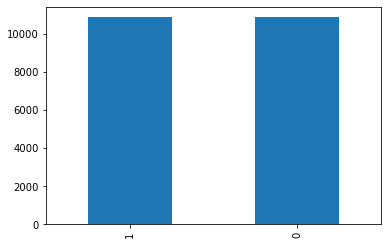

In [9]:
df['category'].value_counts().plot.bar()

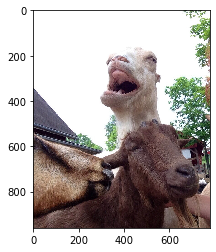

In [10]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka danych

In [11]:
 '''
Podział danych z całego df na X i y:

X - wszystko oprócz category
y - category
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [12]:
df.head()

,filename,category
0,../data/Photos/originals/7ak2w6.jpg,1
1,../data/Photos/originals/27lsoy.jpg,1
2,../data/Photos/originals/7g0q9a.jpg,1
3,../data/Photos/photoshops/da1jeqf_0.jpg,0
4,../data/Photos/originals/4ioqrn.jpg,1


In [13]:
X.head()

,filename
0,../data/Photos/originals/7ak2w6.jpg
1,../data/Photos/originals/27lsoy.jpg
2,../data/Photos/originals/7g0q9a.jpg
3,../data/Photos/photoshops/da1jeqf_0.jpg
4,../data/Photos/originals/4ioqrn.jpg


In [14]:
y.head()

0    1
1    1
2    1
3    0
4    1
Name: category, dtype: int64

In [15]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych
test  - 20% danych
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

# Reset indeksów
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

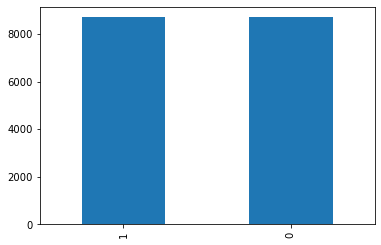

In [16]:
train['category'].value_counts().plot.bar()

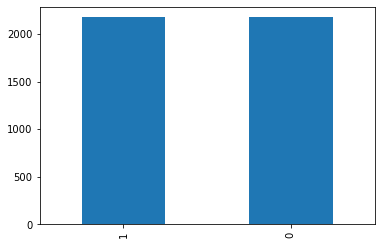

In [17]:
test['category'].value_counts().plot.bar()

In [18]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (21758, 2)
	 train: (17406, 2)
	 test: (4352, 2)


In [19]:
# Upewnienie się że dane w train[filename] i test[filename] są stringiem - lepsze dla generatorów

train['filename'] = train['filename'].astype(str) 
test['filename'] = test['filename'].astype(str)

# Upewnienie się że dane w train[category] i test[category] są stringiem - lepsze dla generatorów

train['category'] = train['category'].astype(str) 
test['category'] = test['category'].astype(str)

In [20]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (21758, 2)
	 train: (17406, 2)
	 test: (4352, 2)


# Funkcję liczące statystyki

In [21]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [22]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [23]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

In [24]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 15
LEARNING_RATE_PATIENCE = 5

# Funkcje do liczenia

In [25]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50

batch_size = 16
activation = 'relu'
loss_type = 'binary_crossentropy'
optimizer = optimizers.RMSprop(lr=2e-5)
dropout = 0.25
epochs = 50

def run(size_w, size_h, fn_size):
    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
    cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
    cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)
    
    # Stałe
    IMAGE_WIDTH=size_w
    IMAGE_HEIGHT=size_h
    IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
    IMAGE_CHANNELS=3
    
    # Generatory
    data_gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True
    )

    data_test_gen = ImageDataGenerator(
        rescale=1./255
    )

    train_generator = data_gen.flow_from_dataframe(
        dataframe = train,
        x_col = 'filename',
        y_col = 'category',
        class_mode='binary',
        target_size=IMAGE_SIZE,
        batch_size=batch_size
    )

    test_generator = data_test_gen.flow_from_dataframe( 
        dataframe = test,
        x_col = 'filename',
        y_col = 'category',
        class_mode='binary',
        target_size=IMAGE_SIZE,
        batch_size=batch_size
    )
    
    # Model
    pre_trained_model_fn = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

    for layer in pre_trained_model_fn.layers[:fn_size]:
        layer.trainable = False

    for layer in pre_trained_model_fn.layers[fn_size:]:
        layer.trainable = True

    model_fn = Sequential()

    model_fn.add(pre_trained_model_fn)
    model_fn.add(Flatten())
    model_fn.add(Dropout(dropout))
    model_fn.add(Dense(256, activation=activation))
    model_fn.add(Dense(1, activation='sigmoid'))

    model_fn.summary()
    
    model_fn.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy'])

    history_fn = model_fn.fit_generator(
        train_generator, 
        epochs = epochs,
        validation_data = test_generator,
        validation_steps = test.shape[0]//batch_size,
        steps_per_epoch = train.shape[0]//batch_size,
        callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
    )

    # Wczytanie najlepszego
    model_fn.load_weights('best.h5')

    # Zapis
    model_fn.save('the_best_fn_P.h5')
    
    # Statystyki
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Wykres loss
    ax1.plot(history_fn.history['loss'], color='b', label="Training loss")
    ax1.plot(history_fn.history['val_loss'], color='r', label="Validation loss")
    ax1.set_xticks(numpy.arange(0, len(history_fn.history['val_loss']), 1))
    ax1.legend(loc='best', shadow=True)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')

    # Wykres accuracy
    ax2.plot(history_fn.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history_fn.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(numpy.arange(0, len(history_fn.history['val_accuracy']), 1))
    ax2.legend(loc='best', shadow=True)
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')


    plt.tight_layout()
    plt.show()
    
    stats_df = pd.DataFrame({
        'filename': test['filename'],
        'category': test['category'],
        'predict_fn': None
    })

    # Mieszamy!
    stats_df = stats_df.sample(frac=1).reset_index(drop=True)

    stats_df.head()
    
    validate_generator = data_gen.flow_from_dataframe( 
        dataframe = stats_df,
        x_col = 'filename',
        class_mode=None,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        shuffle=False
    )
    
    predict_fn = model_fn.predict_generator(validate_generator, verbose=True)
    
    # Zamiana z 0-1 hot encodera na jedno wyjście
    stats_df['predict_fn'] = list(map(lambda x: 1 if x > 0.5 else 0,predict_fn))
    
    y_true_fn = stats_df['category'].to_numpy().astype(int)
    y_pred_fn = stats_df['predict_fn'].to_numpy().astype(int)
    
    cm_fn = confusion_matrix(y_true_fn, y_pred_fn)
    plot_cm(cm_fn, ['Originals', 'Photoshops'])
    
    print(cm_fn)
    
    loss, accuracy  = model_fn.evaluate_generator(test_generator, verbose=True)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

    accuracy, precision, recall, fscore = countStats(y_true_fn, y_pred_fn)
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 36,642,305
Non-trainable params: 53,120
______________________________________________

1087/1087 [==============================] - 309s 284ms/step - loss: 0.4310 - accuracy: 0.7982 - val_loss: 2.0829 - val_accuracy: 0.5710

Epoch 00034: val_loss did not improve from 0.44364
Epoch 35/50
1087/1087 [==============================] - 297s 273ms/step - loss: 0.4318 - accuracy: 0.7960 - val_loss: 1.5417 - val_accuracy: 0.5694

Epoch 00035: val_loss did not improve from 0.44364
Epoch 36/50
1087/1087 [==============================] - 298s 274ms/step - loss: 0.4316 - accuracy: 0.7961 - val_loss: 0.8071 - val_accuracy: 0.5705

Epoch 00036: val_loss did not improve from 0.44364
Epoch 37/50
1087/1087 [==============================] - 295s 271ms/step - loss: 0.4388 - accuracy: 0.7930 - val_loss: 0.7336 - val_accuracy: 0.5685

Epoch 00037: val_loss did not improve from 0.44364
Epoch 38/50
1087/1087 [==============================] - 294s 271ms/step - loss: 0.4336 - accuracy: 0.7940 - val_loss: 0.8755 - val_accuracy: 0.5712

Epoch 00038: val_loss did not improve from 0.44364

Epoch 

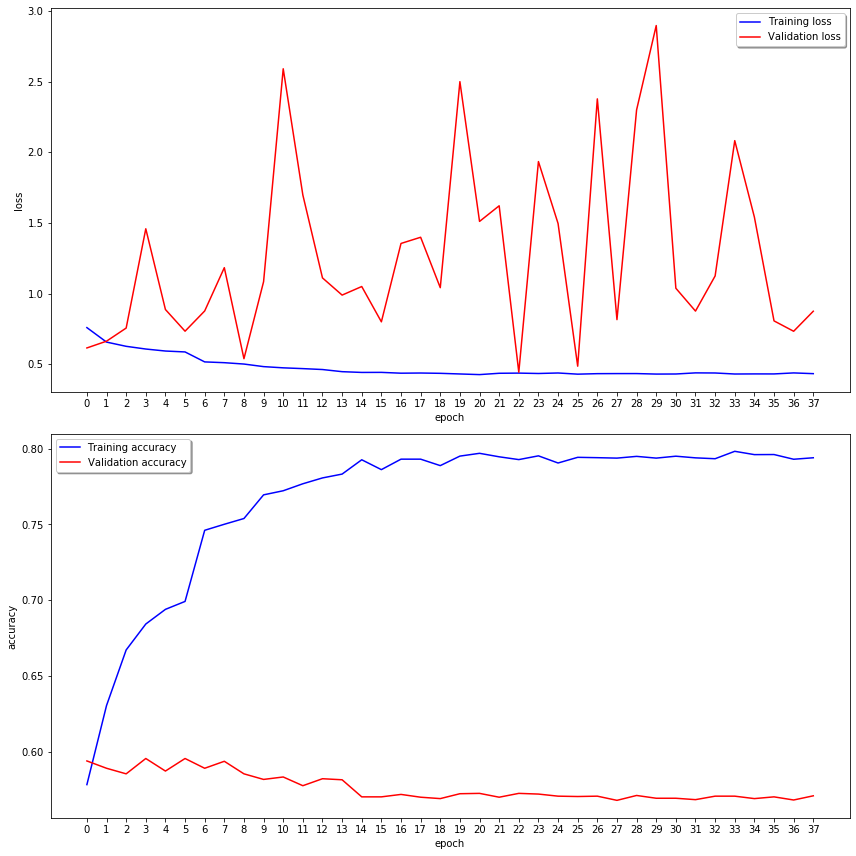

Found 4352 validated image filenames.
272/272 [==============================] - 55s 202ms/step
[[1117 1059]
 [ 819 1357]]
272/272 [==============================] - 56s 207ms/step
Test loss: 1.95
Test accuracy: 0.573
Accuracy: 0.5684742647058824
Precision: 0.5693174976739095
Recall: 0.5684742647058824
F-score: 0.5671579061538253


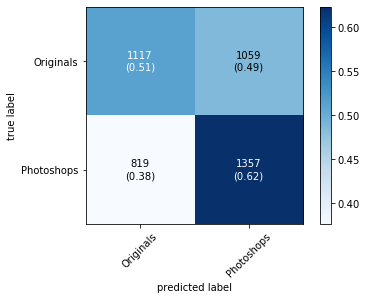

In [26]:
run(150, 150, 0)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 36,415,489
Non-trainable params: 279,936
_____________________________________________

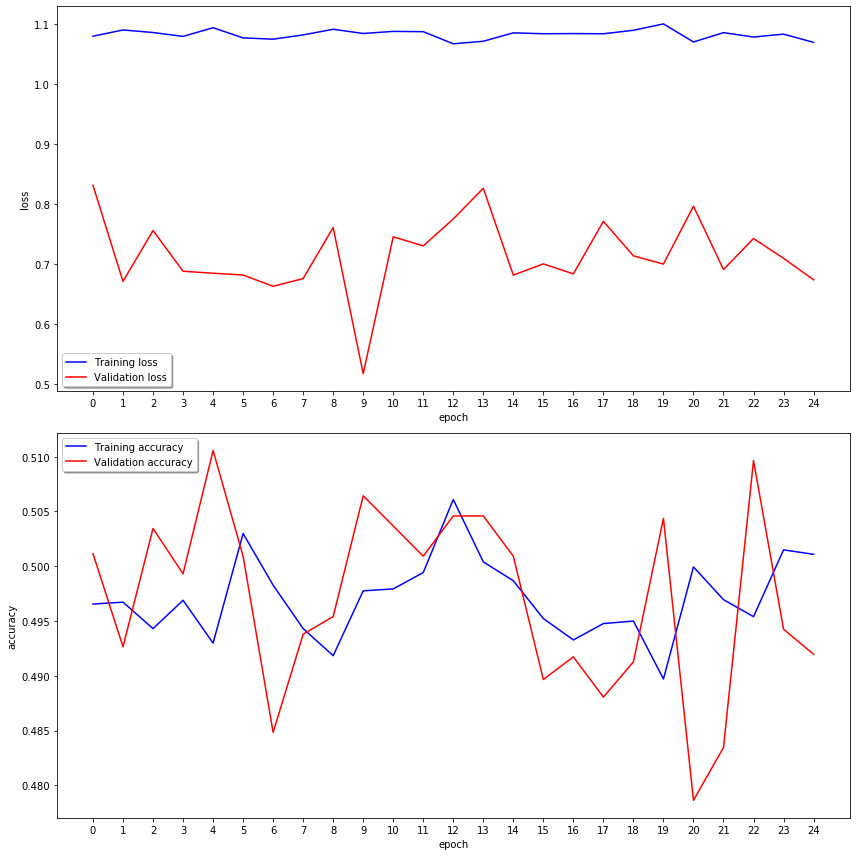

Found 4352 validated image filenames.
272/272 [==============================] - 56s 204ms/step
[[ 193 1983]
 [ 161 2015]]
272/272 [==============================] - 54s 200ms/step
Test loss: 0.793
Test accuracy: 0.506
Accuracy: 0.5073529411764706
Precision: 0.5245998705567474
Recall: 0.5073529411764706
F-score: 0.40265322767541045


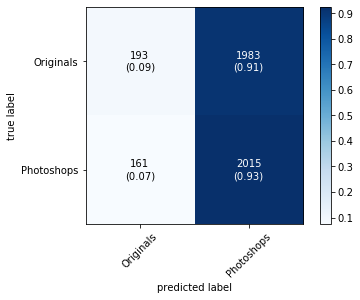

In [27]:
run(150, 150, 39)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 35,192,321
Non-trainable params: 1,503,104
___________________________________________

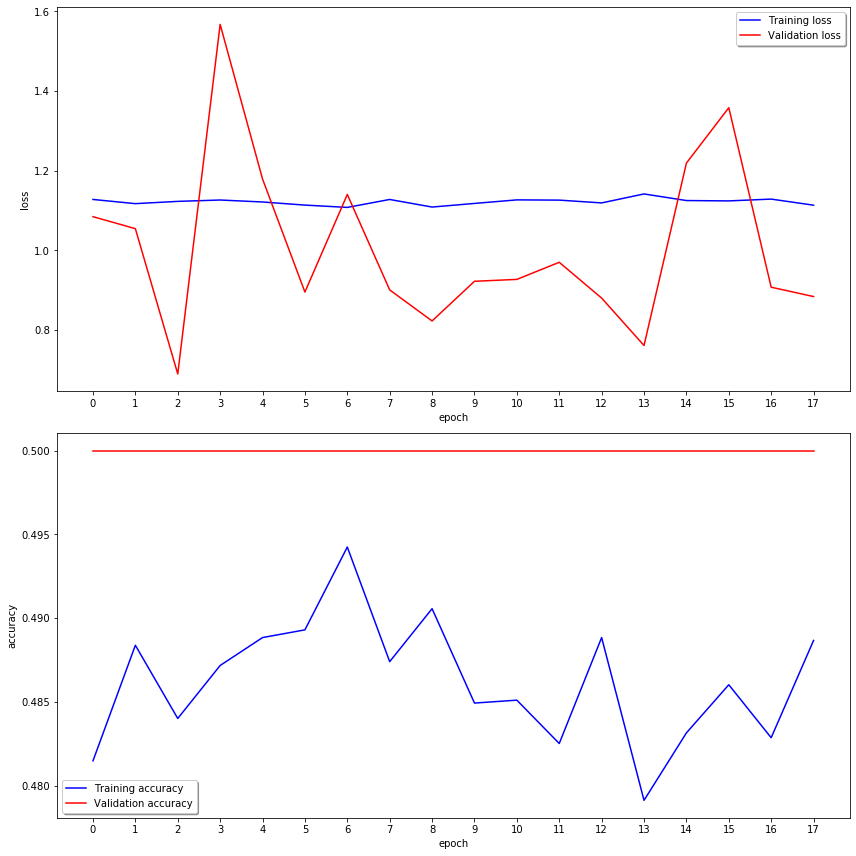

Found 4352 validated image filenames.
272/272 [==============================] - 56s 204ms/step
[[   0 2176]
 [   0 2176]]
272/272 [==============================] - 55s 201ms/step
Test loss: 1.47
Test accuracy: 0.5
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-score: 0.3333333333333333


d:\programs\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


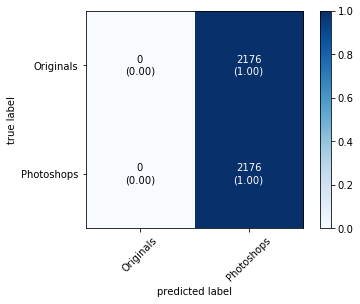

In [28]:
run(150, 150, 81)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 28,083,713
Non-trainable params: 8,611,712
___________________________________________

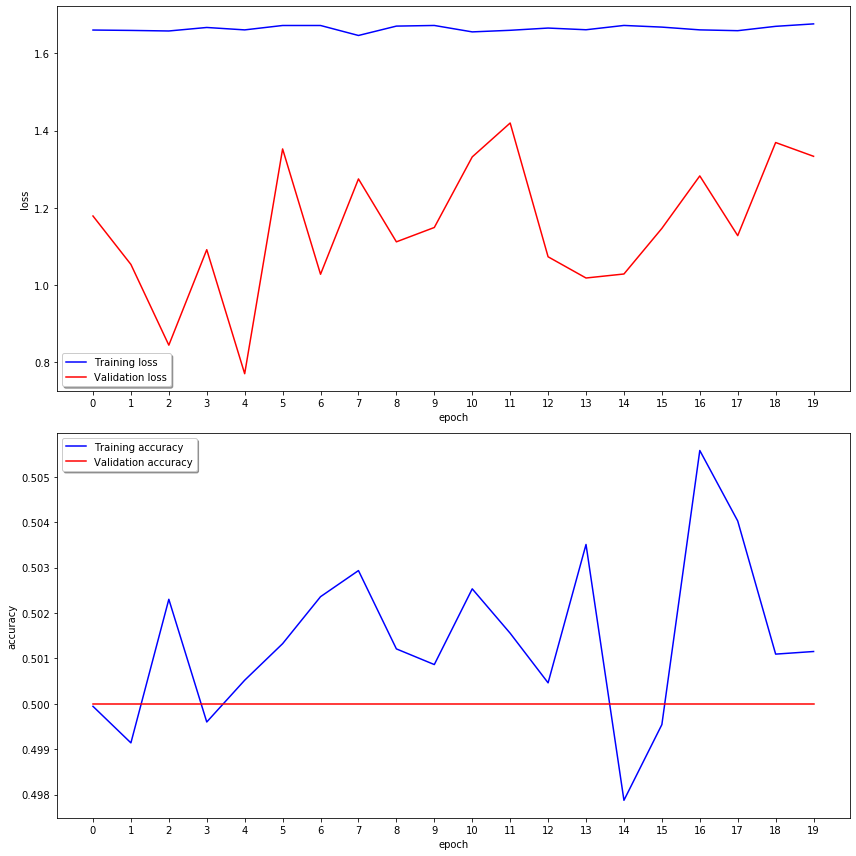

Found 4352 validated image filenames.
272/272 [==============================] - 57s 210ms/step
[[   0 2176]
 [   0 2176]]
272/272 [==============================] - 56s 206ms/step
Test loss: 1.36
Test accuracy: 0.5
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-score: 0.3333333333333333


d:\programs\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


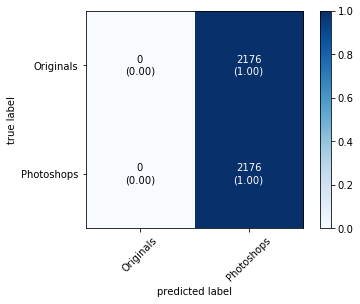

In [29]:
run(150, 150, 143)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
__________________________________________

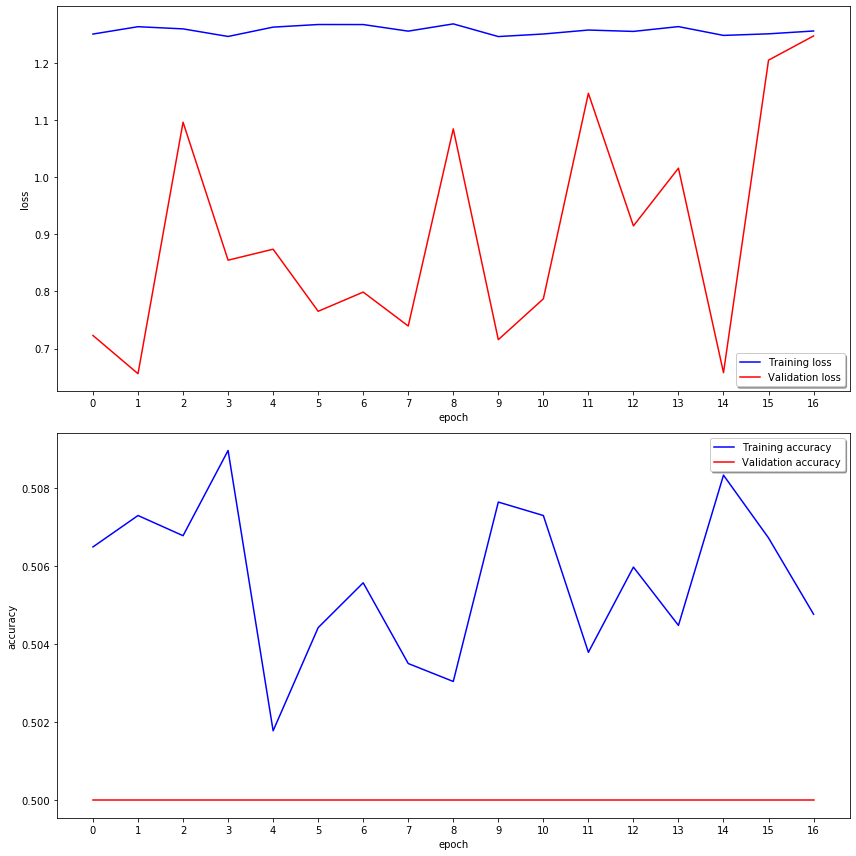

Found 4352 validated image filenames.
272/272 [==============================] - 57s 210ms/step
[[   0 2176]
 [   0 2176]]
272/272 [==============================] - 56s 205ms/step
Test loss: 0.82
Test accuracy: 0.5
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-score: 0.3333333333333333


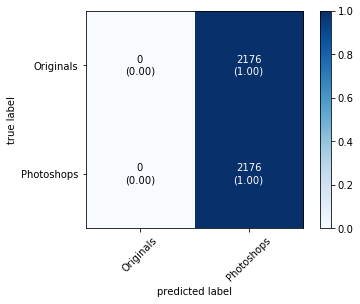

In [30]:
run(150, 150, 177)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 49,278,337
Trainable params: 49,225,217
Non-trainable params: 53,120
______________________________________________

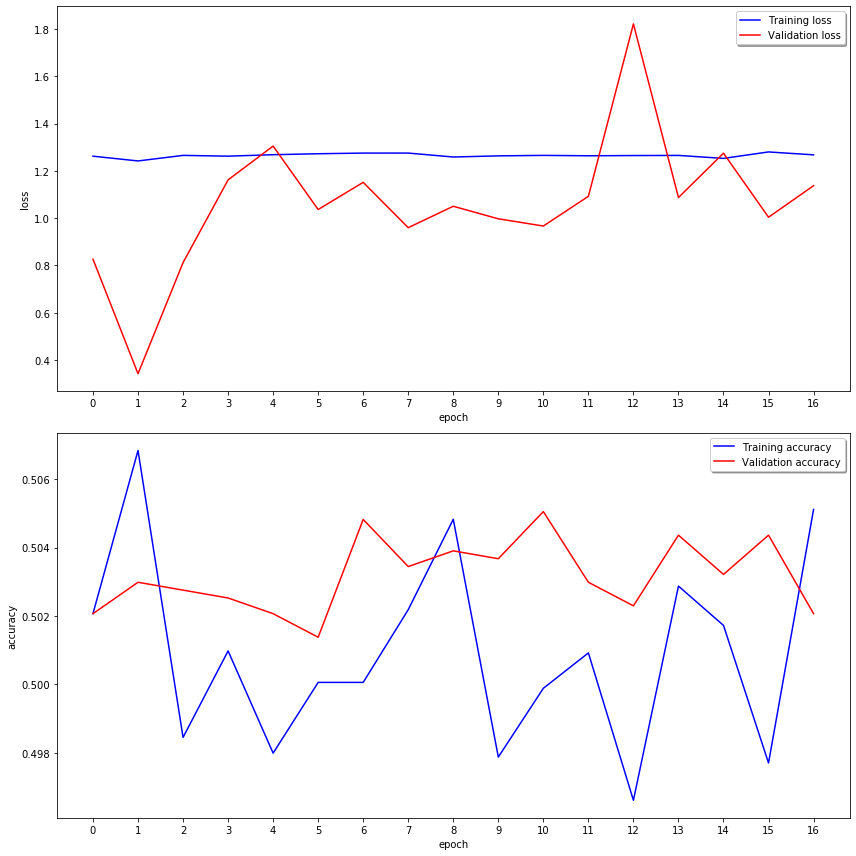

Found 4352 validated image filenames.
272/272 [==============================] - 61s 222ms/step
[[1782  394]
 [1755  421]]
272/272 [==============================] - 58s 214ms/step
Test loss: 1.01
Test accuracy: 0.503
Accuracy: 0.5062040441176471
Precision: 0.510190605535522
Recall: 0.5062040441176471
F-score: 0.4526757821746937


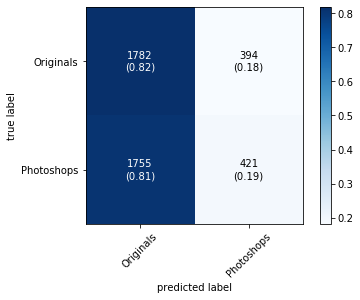

In [31]:
run(224, 224, 0)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 49,278,337
Trainable params: 48,998,401
Non-trainable params: 279,936
_____________________________________________

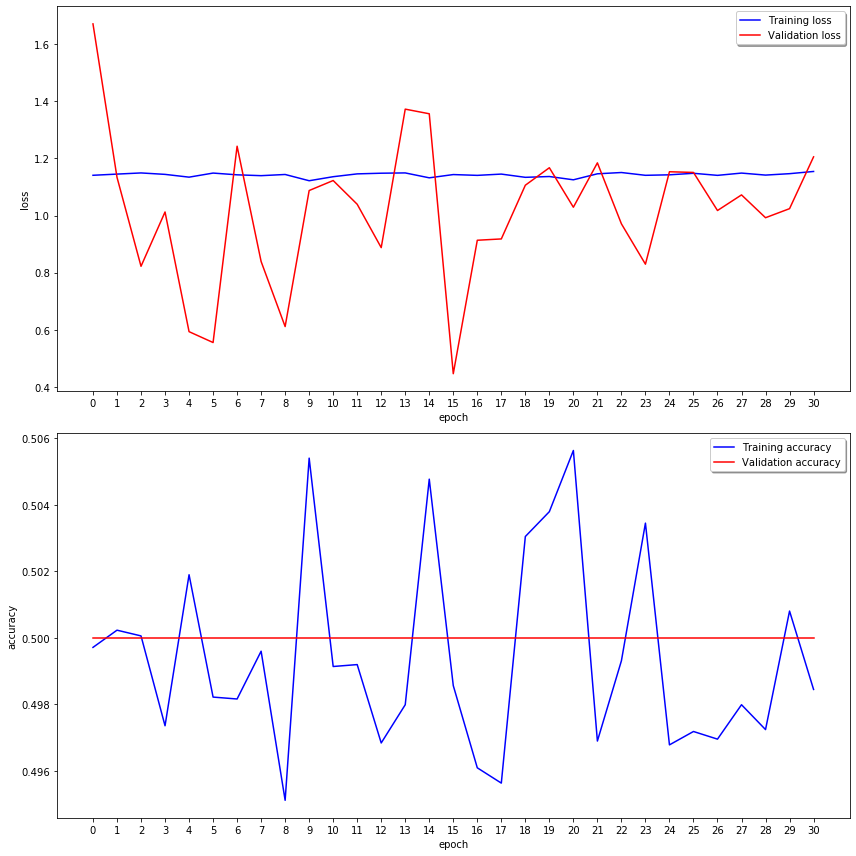

Found 4352 validated image filenames.
272/272 [==============================] - 60s 222ms/step
[[   0 2176]
 [   0 2176]]
272/272 [==============================] - 58s 213ms/step
Test loss: 1.41
Test accuracy: 0.5
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-score: 0.3333333333333333


d:\programs\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


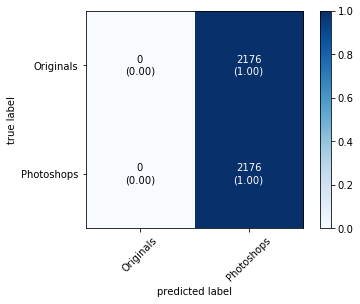

In [32]:
run(224, 224, 39)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 49,278,337
Trainable params: 47,775,233
Non-trainable params: 1,503,104
___________________________________________


Epoch 00033: val_loss did not improve from 0.58511
Epoch 34/50
1087/1087 [==============================] - 403s 371ms/step - loss: 1.1264 - accuracy: 0.4909 - val_loss: 0.8670 - val_accuracy: 0.5000

Epoch 00034: val_loss did not improve from 0.58511
Epoch 35/50
1087/1087 [==============================] - 397s 365ms/step - loss: 1.1258 - accuracy: 0.4947 - val_loss: 1.0929 - val_accuracy: 0.5000

Epoch 00035: val_loss did not improve from 0.58511
Epoch 36/50
1087/1087 [==============================] - 397s 365ms/step - loss: 1.1190 - accuracy: 0.4965 - val_loss: 0.9177 - val_accuracy: 0.5000

Epoch 00036: val_loss did not improve from 0.58511

Epoch 00036: ReduceLROnPlateau reducing learning rate to 1.9999998638134637e-34.
Epoch 00036: early stopping


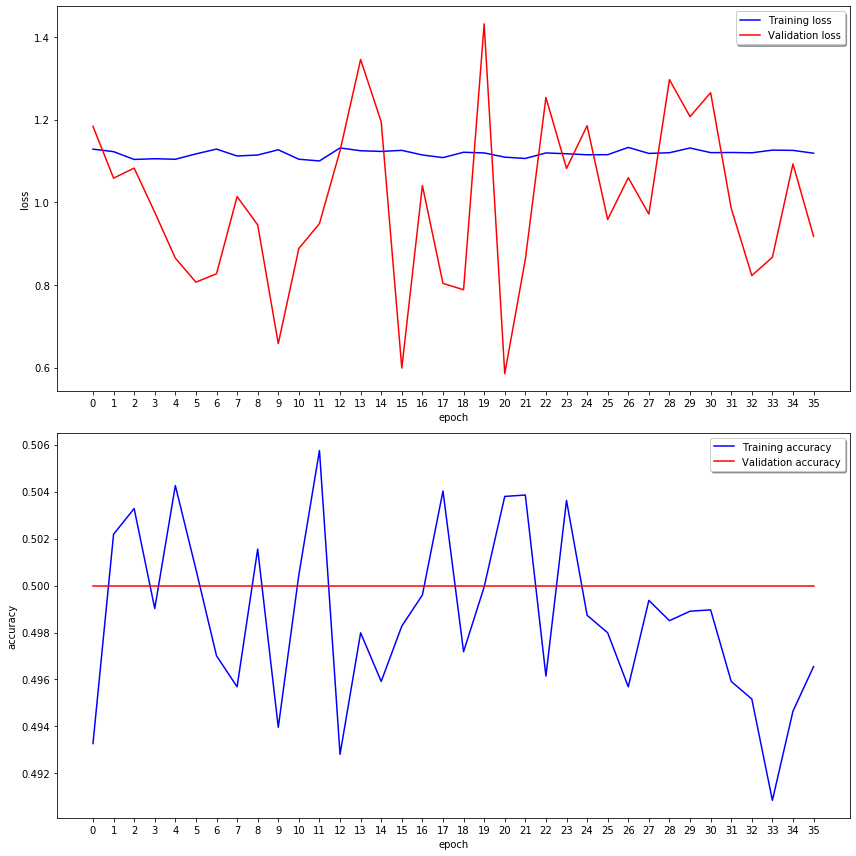

Found 4352 validated image filenames.
272/272 [==============================] - 60s 222ms/step
[[2176    0]
 [2176    0]]
272/272 [==============================] - 58s 213ms/step
Test loss: 0.997
Test accuracy: 0.5
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-score: 0.3333333333333333


d:\programs\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


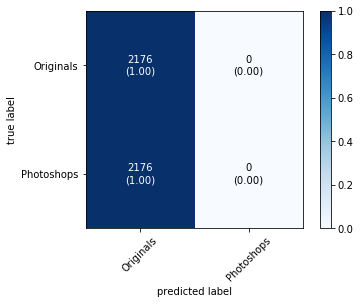

In [33]:
run(224, 224, 81)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 49,278,337
Trainable params: 40,666,625
Non-trainable params: 8,611,712
___________________________________________


Epoch 00033: val_loss did not improve from 0.62406
Epoch 34/50
1087/1087 [==============================] - 406s 374ms/step - loss: 1.7524 - accuracy: 0.5015 - val_loss: 1.2905 - val_accuracy: 0.5000

Epoch 00034: val_loss did not improve from 0.62406
Epoch 35/50
1087/1087 [==============================] - 402s 370ms/step - loss: 1.7633 - accuracy: 0.5003 - val_loss: 1.2838 - val_accuracy: 0.5000

Epoch 00035: val_loss did not improve from 0.62406
Epoch 36/50
1087/1087 [==============================] - 402s 370ms/step - loss: 1.7577 - accuracy: 0.4988 - val_loss: 1.7270 - val_accuracy: 0.5000

Epoch 00036: val_loss did not improve from 0.62406
Epoch 37/50
1087/1087 [==============================] - 406s 374ms/step - loss: 1.7569 - accuracy: 0.5047 - val_loss: 0.9718 - val_accuracy: 0.5000

Epoch 00037: val_loss did not improve from 0.62406

Epoch 00037: ReduceLROnPlateau reducing learning rate to 2.0000000102211275e-39.
Epoch 00037: early stopping


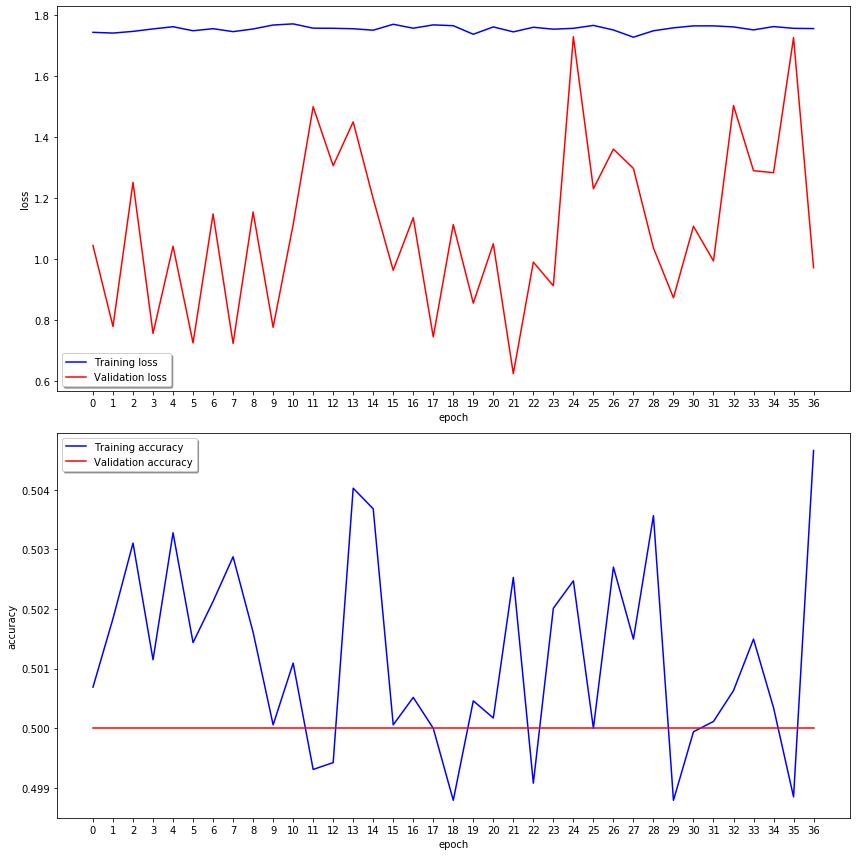

Found 4352 validated image filenames.
272/272 [==============================] - 59s 218ms/step
[[   0 2176]
 [   0 2176]]
272/272 [==============================] - 59s 216ms/step
Test loss: 1.04
Test accuracy: 0.5
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-score: 0.3333333333333333


d:\programs\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


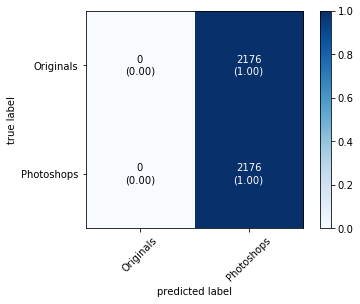

In [34]:
run(224, 224, 143)

Found 17406 validated image filenames belonging to 2 classes.
Found 4352 validated image filenames belonging to 2 classes.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_10 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________

1087/1087 [==============================] - 413s 380ms/step - loss: 1.1037 - accuracy: 0.4899 - val_loss: 0.7934 - val_accuracy: 0.5002

Epoch 00034: val_loss did not improve from 0.57532
Epoch 35/50
1087/1087 [==============================] - 410s 377ms/step - loss: 1.1100 - accuracy: 0.4900 - val_loss: 0.7483 - val_accuracy: 0.5002

Epoch 00035: val_loss did not improve from 0.57532
Epoch 36/50
1087/1087 [==============================] - 411s 378ms/step - loss: 1.1175 - accuracy: 0.4873 - val_loss: 0.7426 - val_accuracy: 0.5002

Epoch 00036: val_loss did not improve from 0.57532
Epoch 37/50
1087/1087 [==============================] - 411s 378ms/step - loss: 1.0993 - accuracy: 0.4923 - val_loss: 0.6712 - val_accuracy: 0.5002

Epoch 00037: val_loss did not improve from 0.57532

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.9996529085915142e-43.
Epoch 38/50
1087/1087 [==============================] - 409s 376ms/step - loss: 1.1183 - accuracy: 0.4848 - val_loss: 0.7575 

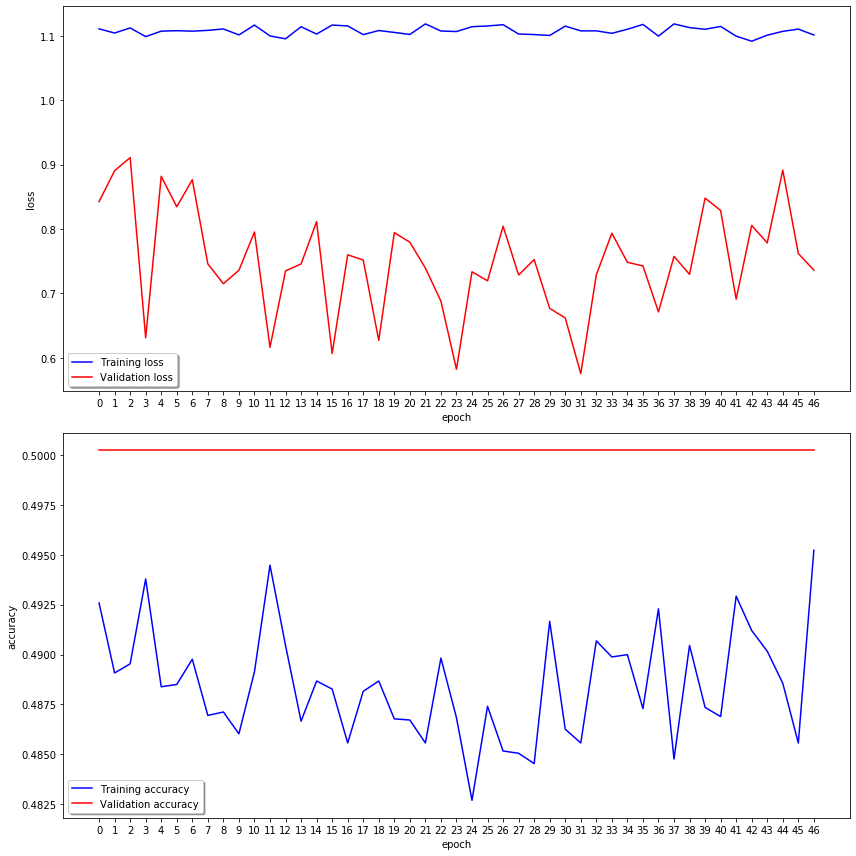

Found 4352 validated image filenames.
272/272 [==============================] - 61s 225ms/step
[[   3 2173]
 [   4 2172]]
272/272 [==============================] - 58s 214ms/step
Test loss: 0.685
Test accuracy: 0.5
Accuracy: 0.4997702205882353
Precision: 0.4642281768864047
Recall: 0.4997702205882353
F-score: 0.3344520044230757


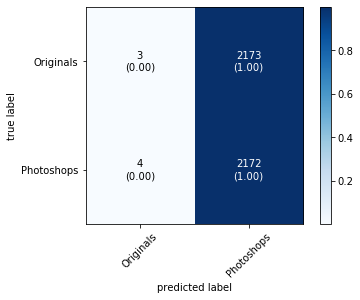

In [35]:
run(224, 224, 177)